In [1]:
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np

import json
from ast import literal_eval  # OP = OP, NP = P (by Articuno's Law)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso

%matplotlib inline

In [2]:
df = pd.read_json('data/recipes.json')

In [3]:
df.submitted = df.submitted.astype('datetime64')

In [4]:
# Recipes which take more than 5 hours
df = df[df['minutes'] < 300]

In [5]:
# We don't want oven or dessert recipes
index = df.tags.to_numpy()
f = lambda x: ('desserts' not in x and 'oven' not in x)
index = [f(x) for x in index]
df = df[index]

In [6]:
irr = ['s', 'with', 'and', 'the', 'for']

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

def generate_wordcloud(name, series=None, freq=None, irrelevant_words=[], bg='white') -> Counter:
    """Plot wordcloud given series of text.
    
    :param name: name of the figure to save
    :param series: the pd.Series of text
    :param freq: the dictionary of frequencies
    :param irrelevant_words: list of words to exclude
    :param bg: the background color for the cloud
    :return: a collections.Counter of every word
    """
    lo = None
    if series is not None:
        lucastemmer = PorterStemmer()
        text = [lucastemmer.stem(term) for term in word_tokenize(series.str.cat(sep=' '))]
        lo = Counter(text)
        irr = ['s', 'with', 'and']
        lo = {k:v for k,v in lo.items() if k not in irrelevant_words}
    else:
        lo = freq
    
    # Plot
    wordcloud = WordCloud(width = 1920, height = 1080, 
                background_color = bg, 
                stopwords = [' ', '  '], 
                min_font_size = 10).generate_from_frequencies(lo) 

    # plot the WordCloud image
    plt.figure(figsize = (19.2, 10.8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.savefig('imgs/{}.png'.format(name))

    plt.show()
    
    return lo

# Create vocabulary

In [8]:
df['ings'] = df.ingredients.apply(lambda x: ' '.join(['_'.join(ing.split(' ')) for ing in x]))

In [9]:
docs = df.ings.to_numpy()

In [10]:
# Set binary True for 0-1 instead of frequency
vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda x: x.split(' '), binary=True, min_df=20)

In [11]:
X = vectorizer.fit_transform(docs)

In [12]:
Y = ((df.std_rating - df.std_rating.mean()) / df.std_rating.std()).to_numpy()

In [13]:
feat_names = vectorizer.get_feature_names()

# Apply linear regression to dataset

In [14]:
model = LinearRegression()

In [15]:
model.fit(X, Y);

In [16]:
ing_contr = dict(zip(feat_names, model.coef_))

In [17]:
ing_contr = dict(sorted(ing_contr.items(), key=lambda kv: kv[1], reverse=True))

In [18]:
ing_contr  # Most controversial according to linear regressor

{'dry_pectin': 0.6975583731628884,
 'liquid_pectin': 0.6202257763074664,
 'low_fat_mozzarella': 0.6084620843481728,
 'white_cranberry_juice': 0.6079582311463027,
 'veal_stock': 0.5944185962349421,
 'liquid_fruit_pectin': 0.5897841385622677,
 'fruit_pectin': 0.5639646204424584,
 'no-added-salt_tomato_paste': 0.5609555049591615,
 'turnip_greens': 0.5565841694344787,
 'mahi_mahi_fillets': 0.5559856041475393,
 'ground_marjoram': 0.5473328446047849,
 'capicola': 0.5367251452194803,
 'garlic_heads': 0.5247238845659132,
 'hot_chicken_broth': 0.5125542616902669,
 'saltine_crumbs': 0.490908238249024,
 'mostaccioli_pasta': 0.4837497670657303,
 'pickling_salt': 0.47866465912851164,
 'roasted_sweet_red_peppers': 0.4748220188664828,
 'simply_potatoes_shredded_hash_browns': 0.47408532149971133,
 'bartlett_pears': 0.4626100186984949,
 'lamb_shoulder': 0.462360838743934,
 'boneless_round_steak': 0.46076723215159804,
 'heinz_ketchup': 0.46035835354127624,
 'greek_oregano': 0.4571928325157113,
 'dried_p

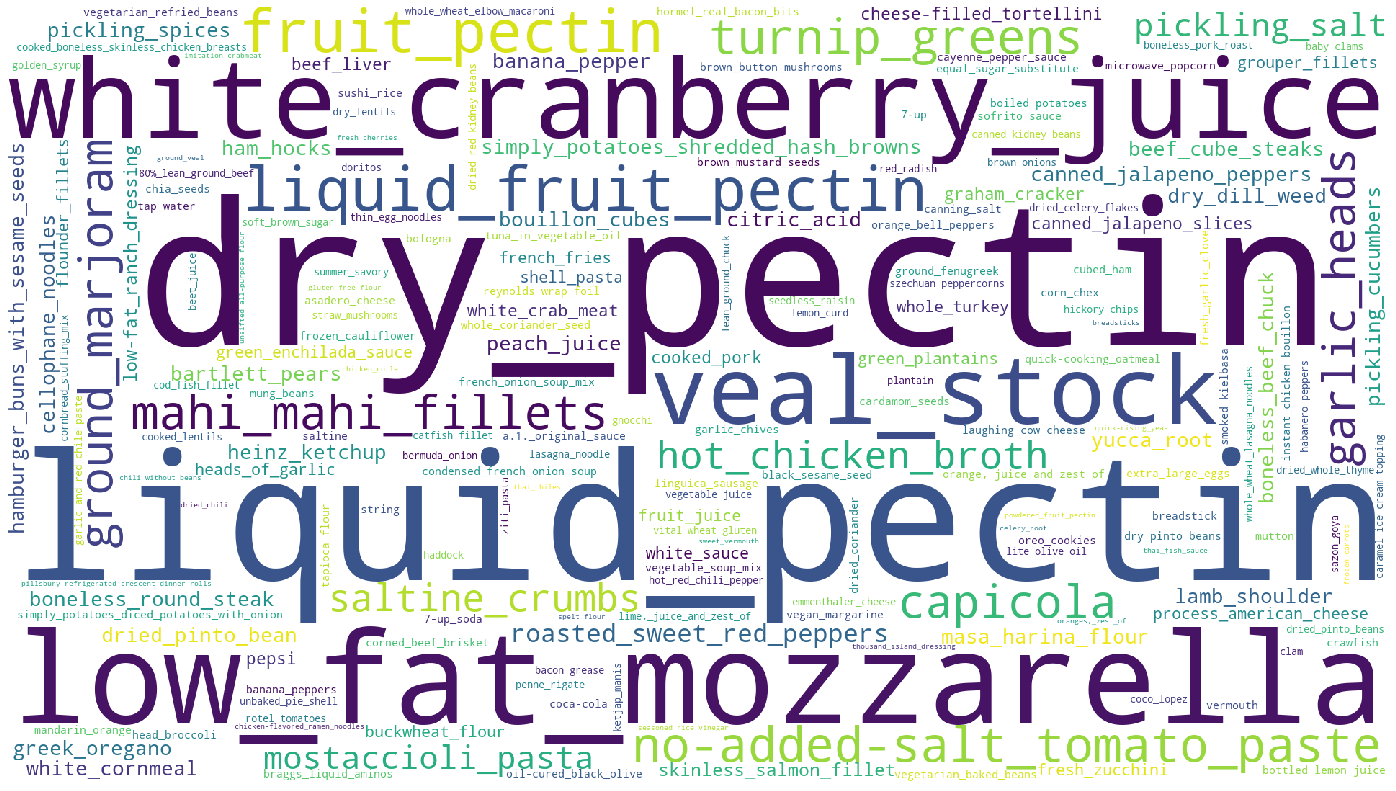

In [19]:
lo_diff_cloud_bad = generate_wordcloud('reg_std_high', None, ing_contr, irr)

In [20]:
ing_contr2 = dict(sorted(ing_contr.items(), key=lambda kv: kv[1]))

In [21]:
ing_contr2

{'tiny_peas': -0.5685464707447365,
 'agave_syrup': -0.5235898161028449,
 'black_vinegar': -0.5053423558135178,
 'french_vanilla_flavored_coffee_creamer': -0.48818283289526615,
 'dried_great_northern_beans': -0.4828781277547729,
 'corn_flakes_cereal': -0.4786073031681426,
 'edam_cheese': -0.476751580221802,
 'extra_large_egg': -0.4751869248990074,
 'mixed_berry': -0.4665335640362213,
 'coffee_ice_cream': -0.46589736861433645,
 'white_truffle_oil': -0.4623104838580059,
 'hing': -0.4432430494396832,
 'brown_sugar_substitute': -0.4327754450535215,
 'cooked_pumpkin': -0.4304287284977774,
 'mexican_chocolate': -0.4299594162788235,
 'plum_jam': -0.42800056566990374,
 'chablis': -0.42359317243395705,
 'fresh_peach': -0.42211349274212623,
 'dried_lavender': -0.4110350177026682,
 'italian_pork_sausage': -0.40865086914745735,
 'refrigerated_pie_crust': -0.4051378186135614,
 'red_ripe_tomatoes': -0.40406686997652125,
 'russian_salad_dressing': -0.40223167603182436,
 'dry_buttermilk': -0.3915699793

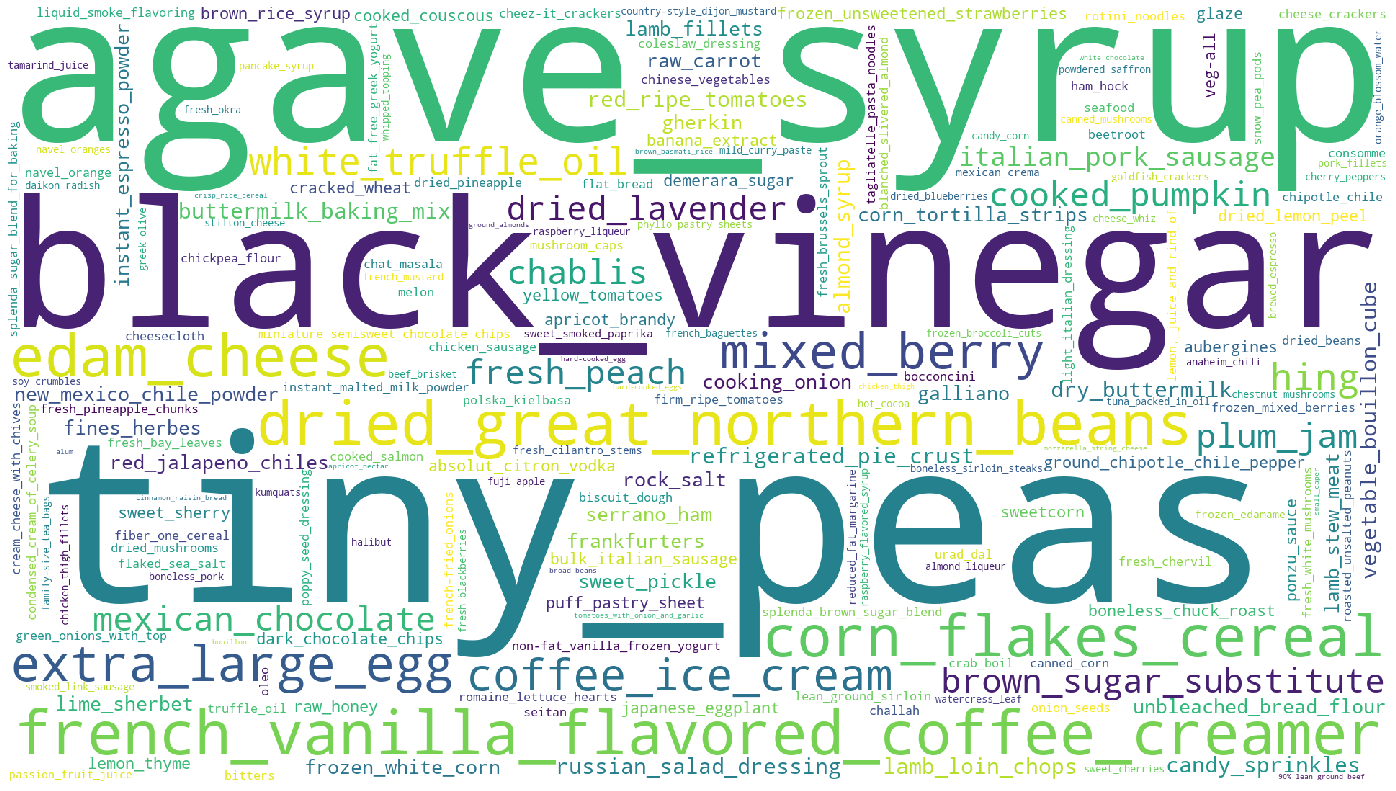

In [22]:
lo_diff_cloud_good = generate_wordcloud('reg_std_low', None, {k:-v for k, v in ing_contr.items()}, irr)

In [23]:
ings = df.ings.to_numpy()

In [24]:
index = ['tiny_peas' in entry for entry in ings]

In [25]:
df[index]

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,n_votes,avg_rating,std_rating,ings
62543,aunt rebecca s creamed potatoes peas,30,58407,2003-05-19,"[30-minutes-or-less, time-to-make, course, mai...","[579.1, 44.0, 29.0, 20.0, 27.0, 69.0, 22.0]",14,"[in 2-qt, saucepan place potatoes, add enough ...","new red potatoes and peas served in a rich, ba...","[red potatoes, bacon, red onion, all-purpose f...",9,4,5.000000,0.000000,red_potatoes bacon red_onion all-purpose_flour...
415550,buttered snow and green peas,7,542159,2010-03-06,"[15-minutes-or-less, time-to-make, preparation...","[86.1, 4.0, 19.0, 1.0, 8.0, 9.0, 3.0]",8,[blanch peas in boiling salt water for no more...,a buttery mix of both snow peas and green peas...,"[snow peas, tiny peas, butter, fresh chives, s...",5,12,4.916667,0.288675,snow_peas tiny_peas butter fresh_chives salt_a...
284466,buttered sugar snaps and green peas,25,311003,2008-02-05,"[30-minutes-or-less, time-to-make, course, mai...","[74.1, 4.0, 11.0, 4.0, 6.0, 9.0, 3.0]",12,[bring a large skillet half full of lightly sa...,this is one of the side dishes that is always ...,"[sugar snap pea, tiny peas, butter, salt, pepp...",6,4,5.000000,0.000000,sugar_snap_pea tiny_peas butter salt pepper of...
109051,cheesy risi e bisi,35,107334,2005-01-21,"[60-minutes-or-less, time-to-make, course, mai...","[367.3, 17.0, 22.0, 16.0, 24.0, 13.0, 17.0]",11,"[heat a medium skillet over medium high heat, ...",from rachael ray -- this is awesome. so easy a...,"[extra virgin olive oil, garlic, onion, arbori...",10,1,5.000000,0.000000,extra_virgin_olive_oil garlic onion arborio_ri...
166806,chicken or turkey pot pie,110,308515,2006-05-04,"[time-to-make, course, main-ingredient, cuisin...","[476.8, 35.0, 22.0, 13.0, 56.0, 24.0, 12.0]",7,[melt the margarine / butter in a pan at low h...,"ultimate in comfort food dinner, and very easy...","[diced onion, celery rib, green bell pepper, o...",12,2,2.000000,2.828427,diced_onion celery_rib green_bell_pepper olive...
121599,cold dill pea salad,16,177443,2005-05-11,"[30-minutes-or-less, time-to-make, course, mai...","[112.2, 9.0, 18.0, 4.0, 8.0, 16.0, 3.0]",7,[cook the peas according to directions on pack...,this cold salad was a winner among over 600 en...,"[frozen tiny peas, sour cream, dried dill weed...",8,4,4.750000,0.500000,frozen_tiny_peas sour_cream dried_dill_weed dr...
5144,corn and pea salad,12,1534,1999-12-01,"[15-minutes-or-less, time-to-make, course, mai...","[2370.1, 124.0, 1018.0, 160.0, 92.0, 54.0, 129.0]",5,"[drain corn , peas , green beans and pimentos,...",None,"[white corn, tiny peas, cut green beans, onion...",12,9,4.888889,0.333333,white_corn tiny_peas cut_green_beans onion pim...
15306,curried chicken and rice salad,20,21752,2001-12-05,"[30-minutes-or-less, time-to-make, course, mai...","[868.1, 51.0, 44.0, 20.0, 43.0, 24.0, 39.0]",8,[heat 2 tablespoons oil in heavy large skillet...,"i love chicken salads, and i love curried chic...","[olive oil, onion, curry powder, boneless skin...",11,1,3.000000,0.000000,olive_oil onion curry_powder boneless_skinless...
15307,curried pea soup,40,21752,2001-12-05,"[60-minutes-or-less, time-to-make, course, mai...","[231.9, 11.0, 57.0, 4.0, 23.0, 22.0, 10.0]",14,[melt butter in heavy large saucepan over medi...,"this soup is delicious, although some kids may...","[butter, onion, curry powder, vegetable broth,...",8,10,5.000000,0.000000,butter onion curry_powder vegetable_broth tiny...
398784,curried shepherd s pie,45,702251,2009-11-10,"[curries, 60-minutes-or-less, time-to-make, co...","[516.1, 44.0, 27.0, 10.0, 50.0, 59.0, 13.0]",12,"[mash the potatoes with butter and milk, seaso...","a wonderfully spiced lamb, pea, and potato cas...","[potatoes, tiny peas, oil, garlic, onion, curr...",12,1,0.000000,0.000000,potatoes tiny_peas oil garlic onion curry_powd...


# Lasso

In [26]:
model = Lasso()

In [27]:
model.fit(X, Y);

In [28]:
ing_contr = dict(zip(feat_names, model.coef_))

In [29]:
ing_contr = dict(sorted(ing_contr.items(), key=lambda kv: kv[1], reverse=True))

In [30]:
ing_contr  # Most controversial according to linear regressor

{'1%_low-fat_milk': -0.0,
 '10-inch_flour_tortillas': 0.0,
 '2%_cheddar_cheese': -0.0,
 '2%_low-fat_milk': 0.0,
 '35%_cream': -0.0,
 '7-up': 0.0,
 '7-up_soda': 0.0,
 '8-inch_flour_tortillas': 0.0,
 '80%_lean_ground_beef': 0.0,
 '90%_lean_ground_beef': -0.0,
 '98%_fat-free_cream_of_chicken_soup': -0.0,
 '98%_fat-free_cream_of_mushroom_soup': -0.0,
 'a.1._original_sauce': 0.0,
 'absolut_citron_vodka': -0.0,
 'accent_seasoning': 0.0,
 'acorn_squash': 0.0,
 'active_dry_yeast': 0.0,
 'adobo_sauce': 0.0,
 'adobo_seasoning': 0.0,
 'agave_nectar': -0.0,
 'agave_syrup': -0.0,
 'aged_cheddar_cheese': -0.0,
 'albacore_tuna': 0.0,
 'albacore_tuna_in_water': -0.0,
 'ale': 0.0,
 'alfalfa_sprout': -0.0,
 'alfalfa_sprouts': -0.0,
 'alfredo_sauce': -0.0,
 'all-bran_cereal': -0.0,
 'all-purpose_flour': 0.0,
 'all-purpose_white_flour': 0.0,
 'all_purpose_greek_seasoning': -0.0,
 'allspice': 0.0,
 'allspice_berries': -0.0,
 'allspice_berry': -0.0,
 'almond_butter': -0.0,
 'almond_extract': -0.0,
 'almond_

In [31]:
ing_contr2 = dict(sorted(ing_contr.items(), key=lambda kv: kv[1]))

In [32]:
ing_contr2

{'1%_low-fat_milk': -0.0,
 '10-inch_flour_tortillas': 0.0,
 '2%_cheddar_cheese': -0.0,
 '2%_low-fat_milk': 0.0,
 '35%_cream': -0.0,
 '7-up': 0.0,
 '7-up_soda': 0.0,
 '8-inch_flour_tortillas': 0.0,
 '80%_lean_ground_beef': 0.0,
 '90%_lean_ground_beef': -0.0,
 '98%_fat-free_cream_of_chicken_soup': -0.0,
 '98%_fat-free_cream_of_mushroom_soup': -0.0,
 'a.1._original_sauce': 0.0,
 'absolut_citron_vodka': -0.0,
 'accent_seasoning': 0.0,
 'acorn_squash': 0.0,
 'active_dry_yeast': 0.0,
 'adobo_sauce': 0.0,
 'adobo_seasoning': 0.0,
 'agave_nectar': -0.0,
 'agave_syrup': -0.0,
 'aged_cheddar_cheese': -0.0,
 'albacore_tuna': 0.0,
 'albacore_tuna_in_water': -0.0,
 'ale': 0.0,
 'alfalfa_sprout': -0.0,
 'alfalfa_sprouts': -0.0,
 'alfredo_sauce': -0.0,
 'all-bran_cereal': -0.0,
 'all-purpose_flour': 0.0,
 'all-purpose_white_flour': 0.0,
 'all_purpose_greek_seasoning': -0.0,
 'allspice': 0.0,
 'allspice_berries': -0.0,
 'allspice_berry': -0.0,
 'almond_butter': -0.0,
 'almond_extract': -0.0,
 'almond_